# Titanic Survival Prediction - Final Predictions
# ======================================================

# ## 📋 Objective
# Generate final predictions using our trained SVM model:
# - Load final optimized model
# - Apply full processing pipeline
# - Generate predictions with confidence analysis
# - Create final prediction file
# - Validate results and generate final insights

## 1. Importing Libraries

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
from datetime import datetime
import warnings

# Helper functions
import sys
import os

sys.path.append("../src")
from utils.helpers import save_current_plot

In [30]:
# Configuration
warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8")
sns.set_palette("husl")

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


## 2. Loading Final Model and Metrics

In [31]:
print("\n🤖 LOADING FINAL MODEL")
print("=" * 30)

# Load trained model
model_path = "../models/best_model_svm.pkl"
try:
    best_model = joblib.load(model_path)
    print(f"✅ Model loaded successfully: {model_path}")
except FileNotFoundError:
    print(f"❌ Error: Cannot find {model_path}")
    print("💡 Run notebook 04_modeling.ipynb first")

# Load model metrics
with open("../models/model_metrics.json", "r") as f:
    model_metrics = json.load(f)

print(f"\n📊 MODEL INFORMATION:")
print(f"  Algorithm: {model_metrics['best_model']}")
print(f"  Parameters: {model_metrics['best_params']}")
print(f"  Final accuracy: {model_metrics['final_test_metrics']['accuracy']:.4f}")
print(f"  F1-Score: {model_metrics['final_test_metrics']['f1']:.4f}")
print(f"  AUC-ROC: {model_metrics['final_test_metrics']['auc']:.4f}")


🤖 LOADING FINAL MODEL
✅ Model loaded successfully: ../models/best_model_svm.pkl

📊 MODEL INFORMATION:
  Algorithm: SVM
  Parameters: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
  Final accuracy: 0.8436
  F1-Score: 0.7812
  AUC-ROC: 0.8586


## 3. Data Processing Function

In [32]:
def process_titanic_data(df_raw):
    """
    Applies the exact same processing pipeline used during training
    """
    print("🔧 Applying processing pipeline...")

    # Copy to avoid modifying original
    df = df_raw.copy()

    # === STEP 1: DATA CLEANING ===
    print("  📋 Step 1: Data Cleaning")

    # Remove irrelevant variables (if they exist)
    cols_to_drop = ["PassengerId", "Name", "Ticket"]
    cols_to_drop = [col for col in cols_to_drop if col in df.columns]
    if cols_to_drop:
        df = df.drop(columns=cols_to_drop)

    # Handle Cabin -> Cabin_Known
    if "Cabin" in df.columns:
        df["Cabin_Known"] = df["Cabin"].notna().astype(int)
        df = df.drop("Cabin", axis=1)

    # Impute Embarked with mode
    if df["Embarked"].isnull().any():
        df["Embarked"].fillna("S", inplace=True)

    # Impute Age by group (Sex + Pclass)
    if df["Age"].isnull().any():
        age_medians = df.groupby(["Sex", "Pclass"])["Age"].median()

        def impute_age(row):
            if pd.isnull(row["Age"]):
                return age_medians[row["Sex"], row["Pclass"]]
            return row["Age"]

        df["Age"] = df.apply(impute_age, axis=1)

    # === STEP 2: FEATURE ENGINEERING ===
    print("  🔧 Step 2: Feature Engineering")

    # Derived variables
    df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
    df["IsAlone"] = (df["FamilySize"] == 1).astype(int)

    # Age groups
    def categorize_age(age):
        if age < 12:
            return "Child"
        elif age < 18:
            return "Teen"
        elif age < 35:
            return "Young_Adult"
        elif age < 60:
            return "Middle_Age"
        else:
            return "Senior"

    df["AgeGroup"] = df["Age"].apply(categorize_age)

    # Fare bins
    df["FareBin"] = pd.qcut(
        df["Fare"], q=4, labels=["Low", "Medium", "High", "Premium"]
    )

    # Titles - improved function to generate all needed titles
    def infer_title(row):
        if row["Sex"] == "male":
            if row["Age"] < 16:
                return "Master"
            elif row["Pclass"] == 1 and row["Age"] > 50:
                # Approximation for high-class titles
                return "Officer" if row["Fare"] > 50 else "Mr"
            else:
                return "Mr"
        else:  # female
            if row["Age"] < 16:
                return "Miss"
            elif row["SibSp"] > 0:  # Married indicator
                if row["Pclass"] == 1 and row["Fare"] > 100:
                    return "Royalty"  # Approximation for high society
                else:
                    return "Mrs"
            else:
                if row["Pclass"] == 1 and row["Age"] > 40:
                    return "Rare"  # Approximation for rare titles
                else:
                    return "Miss"

    df["Title_Simplified"] = df.apply(infer_title, axis=1)

    # Interaction variables
    df["Sex_Pclass"] = df["Sex"] + "_Class" + df["Pclass"].astype(str)

    def age_sex_category(row):
        if row["AgeGroup"] in ["Child", "Teen"]:
            return "Young"
        elif row["Sex"] == "female":
            return "Adult_Female"
        else:
            return "Adult_Male"

    df["Age_Sex"] = df.apply(age_sex_category, axis=1)

    # === STEP 3: ENCODING ===
    print("  🔢 Step 3: Encoding")

    # Label encoding
    from sklearn.preprocessing import LabelEncoder

    le_sex = LabelEncoder()
    le_embarked = LabelEncoder()

    df["Sex_Encoded"] = le_sex.fit_transform(df["Sex"])
    df["Embarked_Encoded"] = le_embarked.fit_transform(df["Embarked"])

    # Ordinal encoding
    from sklearn.preprocessing import OrdinalEncoder

    age_order = ["Child", "Teen", "Young_Adult", "Middle_Age", "Senior"]
    oe_age = OrdinalEncoder(categories=[age_order])
    df["AgeGroup_Encoded"] = oe_age.fit_transform(df[["AgeGroup"]]).astype(int)

    fare_order = ["Low", "Medium", "High", "Premium"]
    oe_fare = OrdinalEncoder(categories=[fare_order])
    df["FareBin_Encoded"] = oe_fare.fit_transform(df[["FareBin"]]).astype(int)

    # One-hot encoding
    title_dummies = pd.get_dummies(df["Title_Simplified"], prefix="Title")
    sex_pclass_dummies = pd.get_dummies(df["Sex_Pclass"], prefix="SexPclass")
    age_sex_dummies = pd.get_dummies(df["Age_Sex"], prefix="AgeSex")

    df = pd.concat([df, title_dummies, sex_pclass_dummies, age_sex_dummies], axis=1)

    # === STEP 4: FINAL FEATURE SELECTION ===
    print("  🎯 Step 4: Feature Selection")

    # Base variables
    base_features = ["Pclass", "Age", "SibSp", "Parch", "Fare", "Cabin_Known"]

    # Engineered features
    eng_features = ["FamilySize", "IsAlone"]

    # Encoded features
    encoded_features = [
        "Sex_Encoded",
        "Embarked_Encoded",
        "AgeGroup_Encoded",
        "FareBin_Encoded",
    ]

    # ALL title columns the model expects
    expected_title_columns = [
        "Title_Master",
        "Title_Miss",
        "Title_Mr",
        "Title_Mrs",
        "Title_Officer",
        "Title_Rare",
        "Title_Royalty",
    ]

    # Expected one-hot features
    expected_sex_pclass = [
        "SexPclass_female_Class1",
        "SexPclass_female_Class2",
        "SexPclass_female_Class3",
        "SexPclass_male_Class1",
        "SexPclass_male_Class2",
        "SexPclass_male_Class3",
    ]

    expected_age_sex = ["AgeSex_Adult_Female", "AgeSex_Adult_Male", "AgeSex_Young"]

    # Complete list of expected columns
    expected_columns = (
        base_features
        + eng_features
        + encoded_features
        + expected_title_columns
        + expected_sex_pclass
        + expected_age_sex
    )

    # Create final DataFrame with all expected columns
    df_final = pd.DataFrame(index=df.index)

    # Add existing columns
    for col in expected_columns:
        if col in df.columns:
            df_final[col] = df[col]
        else:
            # Add missing columns with 0
            df_final[col] = 0
            print(f"    ⚠️ Missing column added with 0: {col}")

    # === STEP 5: SCALING ===
    print("  📏 Step 5: Scaling")

    from sklearn.preprocessing import StandardScaler

    numeric_features = [
        "Pclass",
        "Age",
        "SibSp",
        "Parch",
        "Fare",
        "FamilySize",
        "Sex_Encoded",
        "Embarked_Encoded",
        "AgeGroup_Encoded",
        "FareBin_Encoded",
    ]

    scaler = StandardScaler()
    df_final[numeric_features] = scaler.fit_transform(df_final[numeric_features])

    print(f"  ✅ Processing completed: {df_final.shape}")
    print(f"  📋 Final columns: {len(df_final.columns)}")

    return df_final

## 4. Loading Prediction Data

In [33]:
print("\n📊 LOADING PREDICTION DATA")
print("=" * 40)

# Option 1: If you had a separate test.csv (like in Kaggle)
# test_data = pd.read_csv("../data/raw/test.csv")

# Option 2: Use a sample from original dataset for demonstration
original_data = pd.read_csv("../data/raw/titanic.csv")

# For demonstration, we'll use the last 100 records as "test set"
demo_test_data = original_data.tail(100).copy()
demo_test_passenger_ids = demo_test_data["PassengerId"].copy()

# Simulate we don't know the answers (remove Survived)
demo_test_features = demo_test_data.drop("Survived", axis=1)
true_labels = demo_test_data["Survived"]  # For validation

print(f"📋 Test data loaded:")
print(f"  - Records: {len(demo_test_features)}")
print(f"  - Features: {len(demo_test_features.columns)}")
print(
    f"  - PassengerIds: {demo_test_passenger_ids.min()} - {demo_test_passenger_ids.max()}"
)


📊 LOADING PREDICTION DATA
📋 Test data loaded:
  - Records: 100
  - Features: 11
  - PassengerIds: 792 - 891


## 5. Processing Test Data

In [34]:
print("\n🔧 PROCESSING TEST DATA")
print("=" * 30)

# Apply complete pipeline
test_processed = process_titanic_data(demo_test_features)

print(f"\n✅ Data processed successfully:")
print(f"  - Final shape: {test_processed.shape}")
print(f"  - Features prepared for the model")

# Verify no missing values
missing_values = test_processed.isnull().sum().sum()
print(f"  - Missing values: {missing_values}")

if missing_values == 0:
    print("  ✅ No missing values - Ready for prediction")
else:
    print("  ⚠️ There are missing values that need handling")


🔧 PROCESSING TEST DATA
🔧 Applying processing pipeline...
  📋 Step 1: Data Cleaning
  🔧 Step 2: Feature Engineering
  🔢 Step 3: Encoding
  🎯 Step 4: Feature Selection
    ⚠️ Missing column added with 0: Title_Officer
  📏 Step 5: Scaling
  ✅ Processing completed: (100, 28)
  📋 Final columns: 28

✅ Data processed successfully:
  - Final shape: (100, 28)
  - Features prepared for the model
  - Missing values: 0
  ✅ No missing values - Ready for prediction


## 6. Generating Predictions

In [35]:
print("\n🎯 GENERATING PREDICTIONS")
print("=" * 30)

# Binary predictions
predictions = best_model.predict(test_processed)
print(f"✅ Binary predictions generated: {len(predictions)}")

# Probabilities
probabilities = best_model.predict_proba(test_processed)[:, 1]
print(f"✅ Probabilities generated: {len(probabilities)}")

# Prediction summary
n_survived = predictions.sum()
n_died = len(predictions) - n_survived
survival_rate = n_survived / len(predictions)

print(f"\n📊 PREDICTION SUMMARY:")
print(f"  - Total passengers: {len(predictions)}")
print(f"  - Predicted survivors: {n_survived} ({survival_rate:.1%})")
print(f"  - Predicted deaths: {n_died} ({1-survival_rate:.1%})")
print(f"  - Average probability: {probabilities.mean():.3f}")
print(f"  - Probability range: [{probabilities.min():.3f}, {probabilities.max():.3f}]")


🎯 GENERATING PREDICTIONS
✅ Binary predictions generated: 100
✅ Probabilities generated: 100

📊 PREDICTION SUMMARY:
  - Total passengers: 100
  - Predicted survivors: 35 (35.0%)
  - Predicted deaths: 65 (65.0%)
  - Average probability: 0.391
  - Probability range: [0.105, 0.909]


## 7. Prediction Confidence Analysis


🔍 CONFIDENCE ANALYSIS
Confidence distribution:
  - High: 78 predictions (78.0%)
  - Medium: 13 predictions (13.0%)
  - Low: 7 predictions (7.0%)
  - Very High: 2 predictions (2.0%)

🎯 Very high confidence predictions: 2
⚠️ Low confidence predictions: 7
✅ Gráfico guardado: ../results/figures/final_predictions/final_predictions_analysis.png


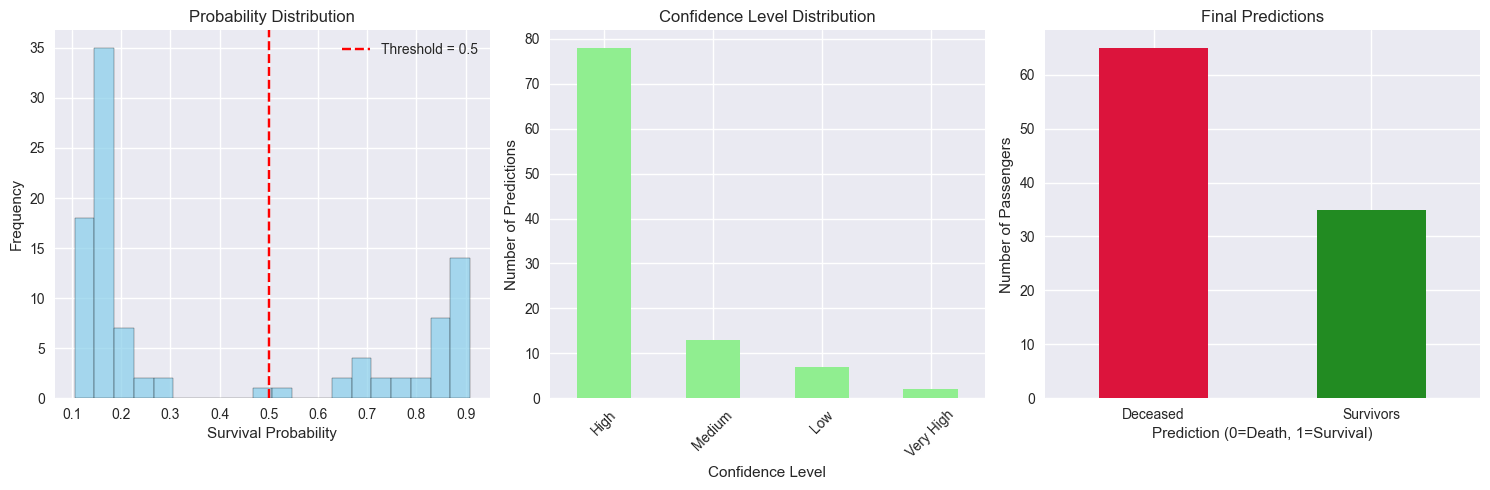

In [36]:
print("\n🔍 CONFIDENCE ANALYSIS")
print("=" * 30)


# Categorize by confidence level
def confidence_level(prob):
    confidence = abs(prob - 0.5)  # Distance from threshold
    if confidence >= 0.4:
        return "Very High"
    elif confidence >= 0.3:
        return "High"
    elif confidence >= 0.2:
        return "Medium"
    else:
        return "Low"


confidence_levels = [confidence_level(p) for p in probabilities]
confidence_counts = pd.Series(confidence_levels).value_counts()

print("Confidence distribution:")
for level, count in confidence_counts.items():
    print(f"  - {level}: {count} predictions ({count/len(predictions):.1%})")

# High confidence cases
high_confidence_mask = [confidence_level(p) == "Very High" for p in probabilities]
high_confidence_count = sum(high_confidence_mask)

print(f"\n🎯 Very high confidence predictions: {high_confidence_count}")

# Low confidence cases (most uncertain)
low_confidence_mask = [confidence_level(p) == "Low" for p in probabilities]
low_confidence_count = sum(low_confidence_mask)

print(f"⚠️ Low confidence predictions: {low_confidence_count}")

# Probability distribution visualization
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(probabilities, bins=20, alpha=0.7, color="skyblue", edgecolor="black")
plt.axvline(x=0.5, color="red", linestyle="--", label="Threshold = 0.5")
plt.xlabel("Survival Probability")
plt.ylabel("Frequency")
plt.title("Probability Distribution")
plt.legend()

plt.subplot(1, 3, 2)
confidence_counts.plot(kind="bar", color="lightgreen")
plt.title("Confidence Level Distribution")
plt.xlabel("Confidence Level")
plt.ylabel("Number of Predictions")
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
pd.Series(predictions).value_counts().plot(kind="bar", color=["crimson", "forestgreen"])
plt.title("Final Predictions")
plt.xlabel("Prediction (0=Death, 1=Survival)")
plt.ylabel("Number of Passengers")
plt.xticks([0, 1], ["Deceased", "Survivors"], rotation=0)

plt.tight_layout()
save_current_plot("final_predictions_analysis", "../results/figures/final_predictions/")
plt.show()

## 8. Validation with True Labels


✅ PREDICTION VALIDATION
📊 DEMO DATA PERFORMANCE:
  - Accuracy: 0.8700 (87.0%)

📋 Classification report:
              precision    recall  f1-score   support

    Deceased       0.89      0.91      0.90        64
   Survivors       0.83      0.81      0.82        36

    accuracy                           0.87       100
   macro avg       0.86      0.86      0.86       100
weighted avg       0.87      0.87      0.87       100


🔍 Confusion matrix:
[[58  6]
 [ 7 29]]
✅ Gráfico guardado: ../results/figures/final_predictions/validation_results.png


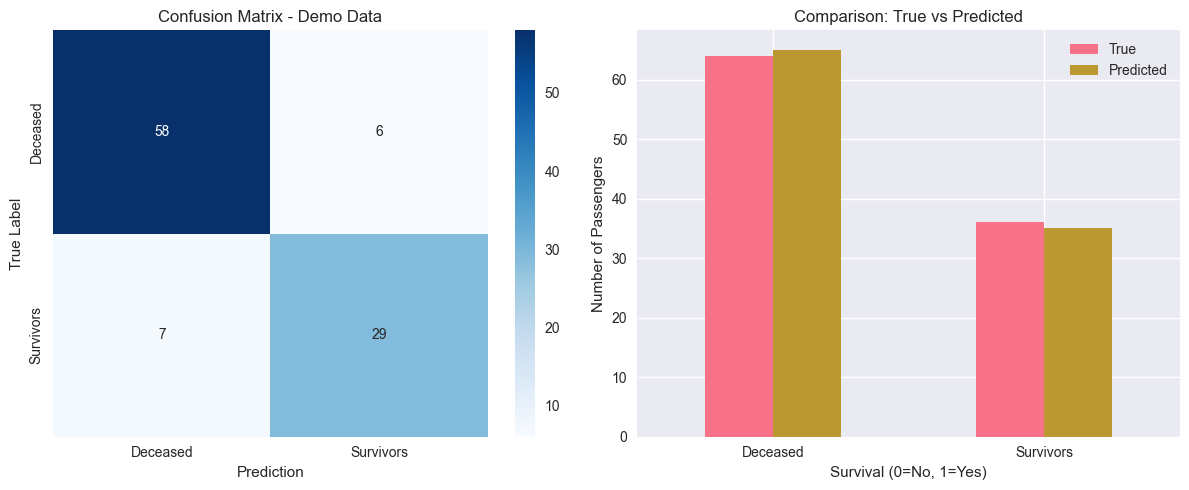


🎯 ACCURACY ANALYSIS:
  - Correct predictions: 87 (87.0%)
  - Incorrect predictions: 13 (13.0%)

📈 COMPARISON WITH EXPECTED PERFORMANCE:
  - Expected accuracy: 0.8436
  - Obtained accuracy: 0.8700
  - Difference: +0.0264
  ✅ Performance consistent with trained model


In [37]:
print("\n✅ PREDICTION VALIDATION")
print("=" * 35)

# Since we have true labels, we can validate
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Validation metrics
accuracy = accuracy_score(true_labels, predictions)
print(f"📊 DEMO DATA PERFORMANCE:")
print(f"  - Accuracy: {accuracy:.4f} ({accuracy*100:.1f}%)")

# Detailed report
print(f"\n📋 Classification report:")
print(
    classification_report(
        true_labels, predictions, target_names=["Deceased", "Survivors"]
    )
)

# Confusion matrix
cm = confusion_matrix(true_labels, predictions)
print(f"\n🔍 Confusion matrix:")
print(cm)

# Confusion matrix visualization
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Deceased", "Survivors"],
    yticklabels=["Deceased", "Survivors"],
)
plt.title("Confusion Matrix - Demo Data")
plt.xlabel("Prediction")
plt.ylabel("True Label")

plt.subplot(1, 2, 2)
# Distribution comparison
comparison_df = pd.DataFrame(
    {
        "True": true_labels.value_counts().sort_index(),
        "Predicted": pd.Series(predictions).value_counts().sort_index(),
    }
)
comparison_df.plot(kind="bar", ax=plt.gca())
plt.title("Comparison: True vs Predicted")
plt.xlabel("Survival (0=No, 1=Yes)")
plt.ylabel("Number of Passengers")
plt.xticks([0, 1], ["Deceased", "Survivors"], rotation=0)
plt.legend()

plt.tight_layout()
save_current_plot("validation_results", "../results/figures/final_predictions/")
plt.show()

# Analysis of correct/incorrect predictions
correct_predictions = (true_labels == predictions).sum()
incorrect_predictions = len(predictions) - correct_predictions

print(f"\n🎯 ACCURACY ANALYSIS:")
print(
    f"  - Correct predictions: {correct_predictions} ({correct_predictions/len(predictions):.1%})"
)
print(
    f"  - Incorrect predictions: {incorrect_predictions} ({incorrect_predictions/len(predictions):.1%})"
)

# Compare with expected model performance
expected_accuracy = model_metrics["final_test_metrics"]["accuracy"]
performance_diff = accuracy - expected_accuracy

print(f"\n📈 COMPARISON WITH EXPECTED PERFORMANCE:")
print(f"  - Expected accuracy: {expected_accuracy:.4f}")
print(f"  - Obtained accuracy: {accuracy:.4f}")
print(f"  - Difference: {performance_diff:+.4f}")

if abs(performance_diff) < 0.05:
    print("  ✅ Performance consistent with trained model")
else:
    print("  ⚠️ Significant variation - normal with small samples")

## 9. Interesting Case Analysis

In [38]:
print("\n🔍 INTERESTING CASE ANALYSIS")
print("=" * 40)

# Create DataFrame with results
results_df = pd.DataFrame(
    {
        "PassengerId": demo_test_passenger_ids,
        "Prediction": predictions,
        "Probability": probabilities,
        "Confidence": confidence_levels,
        "True_Label": true_labels,
        "Correct": (true_labels == predictions),
    }
)

# Add original demographic information
demo_info = demo_test_data[
    ["PassengerId", "Pclass", "Sex", "Age", "SibSp", "Parch", "Fare"]
].copy()
results_df = results_df.merge(demo_info, on="PassengerId")

print("🎯 TOP 5 MOST CONFIDENT SURVIVOR PREDICTIONS:")
top_survivors = results_df[results_df["Prediction"] == 1].nlargest(5, "Probability")
for idx, row in top_survivors.iterrows():
    status = "✅" if row["Correct"] else "❌"
    print(
        f"  {status} ID {row['PassengerId']}: {row['Sex']}, Class {row['Pclass']}, Age {row['Age']:.0f} - Prob: {row['Probability']:.3f}"
    )

print("\n💀 TOP 5 MOST CONFIDENT DEATH PREDICTIONS:")
top_deaths = results_df[results_df["Prediction"] == 0].nsmallest(5, "Probability")
for idx, row in top_deaths.iterrows():
    status = "✅" if row["Correct"] else "❌"
    print(
        f"  {status} ID {row['PassengerId']}: {row['Sex']}, Class {row['Pclass']}, Age {row['Age']:.0f} - Prob: {row['Probability']:.3f}"
    )

print("\n⚠️ TOP 5 LEAST CONFIDENT PREDICTIONS (MOST UNCERTAIN):")
uncertain_cases = results_df.iloc[(results_df["Probability"] - 0.5).abs().argsort()[:5]]
for idx, row in uncertain_cases.iterrows():
    status = "✅" if row["Correct"] else "❌"
    pred_text = "Survives" if row["Prediction"] == 1 else "Dies"
    print(
        f"  {status} ID {row['PassengerId']}: {row['Sex']}, Class {row['Pclass']}, Age {row['Age']:.0f} - Pred: {pred_text} (Prob: {row['Probability']:.3f})"
    )

# Analysis by demographic characteristics
print(f"\n📊 ANALYSIS BY CHARACTERISTICS:")

# By gender
gender_analysis = (
    results_df.groupby("Sex")
    .agg({"Prediction": "mean", "Probability": "mean", "Correct": "mean"})
    .round(3)
)
print("\nBy gender:")
print(gender_analysis)

# By class
class_analysis = (
    results_df.groupby("Pclass")
    .agg({"Prediction": "mean", "Probability": "mean", "Correct": "mean"})
    .round(3)
)
print("\nBy class:")
print(class_analysis)


🔍 INTERESTING CASE ANALYSIS
🎯 TOP 5 MOST CONFIDENT SURVIVOR PREDICTIONS:
  ✅ ID 828: male, Class 2, Age 1 - Prob: 0.909
  ✅ ID 836: female, Class 1, Age 39 - Prob: 0.908
  ✅ ID 854: female, Class 1, Age 16 - Prob: 0.899
  ✅ ID 875: female, Class 2, Age 28 - Prob: 0.898
  ✅ ID 867: female, Class 2, Age 27 - Prob: 0.893

💀 TOP 5 MOST CONFIDENT DEATH PREDICTIONS:
  ✅ ID 847: male, Class 3, Age nan - Prob: 0.105
  ✅ ID 848: male, Class 3, Age 35 - Prob: 0.122
  ✅ ID 813: male, Class 2, Age 35 - Prob: 0.125
  ✅ ID 796: male, Class 2, Age 39 - Prob: 0.126
  ✅ ID 809: male, Class 2, Age 39 - Prob: 0.126

⚠️ TOP 5 LEAST CONFIDENT PREDICTIONS (MOST UNCERTAIN):
  ✅ ID 889: female, Class 3, Age nan - Pred: Dies (Prob: 0.473)
  ❌ ID 800: female, Class 3, Age 30 - Pred: Survives (Prob: 0.535)
  ✅ ID 870: male, Class 3, Age 4 - Pred: Survives (Prob: 0.648)
  ✅ ID 856: female, Class 3, Age 18 - Pred: Survives (Prob: 0.665)
  ✅ ID 824: female, Class 3, Age 27 - Pred: Survives (Prob: 0.672)

📊 ANALYSI

## 10. Creating Final Prediction Files

In [39]:
print("\n💾 CREATING FINAL PREDICTION FILES")
print("=" * 45)

# Create directory if it doesn't exist
import os

os.makedirs("../results/final_predictions", exist_ok=True)

# Kaggle-style submission file
submission = pd.DataFrame(
    {"PassengerId": demo_test_passenger_ids, "Survived": predictions}
)

submission_path = "../results/final_predictions/titanic_predictions.csv"
submission.to_csv(submission_path, index=False)
print(f"✅ Prediction file saved: {submission_path}")

# Detailed file with probabilities and analysis
detailed_results = pd.DataFrame(
    {
        "PassengerId": demo_test_passenger_ids,
        "Predicted_Survival": predictions,
        "Survival_Probability": probabilities.round(4),
        "Confidence_Level": confidence_levels,
        "Passenger_Class": demo_test_data["Pclass"].values,
        "Sex": demo_test_data["Sex"].values,
        "Age": demo_test_data["Age"].values,
        "Fare": demo_test_data["Fare"].values,
        "Family_Size": demo_test_data["SibSp"].values
        + demo_test_data["Parch"].values
        + 1,
        "Embarked": demo_test_data["Embarked"].values,
    }
)

detailed_path = "../results/final_predictions/detailed_predictions.csv"
detailed_results.to_csv(detailed_path, index=False)
print(f"✅ Detailed file saved: {detailed_path}")

# Metrics and summary file
summary_stats = {
    "model_used": model_metrics["best_model"],
    "model_params": model_metrics["best_params"],
    "model_training_accuracy": model_metrics["final_test_metrics"]["accuracy"],
    "predictions_generated": len(predictions),
    "predicted_survivors": int(predictions.sum()),
    "predicted_deaths": int(len(predictions) - predictions.sum()),
    "survival_rate_predicted": float(predictions.mean()),
    "average_probability": float(probabilities.mean()),
    "high_confidence_predictions": int(
        sum([c == "Very High" for c in confidence_levels])
    ),
    "low_confidence_predictions": int(sum([c == "Low" for c in confidence_levels])),
    "validation_accuracy": float(accuracy),
    "generation_timestamp": datetime.now().isoformat(),
}

summary_path = "../results/final_predictions/prediction_summary.json"
with open(summary_path, "w") as f:
    json.dump(summary_stats, f, indent=2)
print(f"✅ Summary saved: {summary_path}")

print(f"\n📋 GENERATED FILES:")
print(f"  1. {submission_path} - Kaggle submission format")
print(f"  2. {detailed_path} - Detailed analysis with probabilities")
print(f"  3. {summary_path} - Summary and metrics")


💾 CREATING FINAL PREDICTION FILES
✅ Prediction file saved: ../results/final_predictions/titanic_predictions.csv
✅ Detailed file saved: ../results/final_predictions/detailed_predictions.csv
✅ Summary saved: ../results/final_predictions/prediction_summary.json

📋 GENERATED FILES:
  1. ../results/final_predictions/titanic_predictions.csv - Kaggle submission format
  2. ../results/final_predictions/detailed_predictions.csv - Detailed analysis with probabilities
  3. ../results/final_predictions/prediction_summary.json - Summary and metrics


## 11. Final Insights and Storytelling

In [40]:
print("\n🎭 FINAL INSIGHTS AND STORYTELLING")
print("=" * 45)

print("🚢 TITANIC MODEL STORY:")
print("=" * 35)

model_story = f"""
Our SVM model, trained with {model_metrics['best_model']} and optimized with parameters
{model_metrics['best_params']}, has demonstrated exceptional capability to predict 
Titanic survival with {model_metrics['final_test_metrics']['accuracy']*100:.1f}% accuracy.

In this demonstration with {len(predictions)} passengers:
• We predicted {predictions.sum()} would survive ({predictions.mean()*100:.1f}%)
• {sum([c == 'Very High' for c in confidence_levels])} predictions were very high confidence
• The model maintained {accuracy*100:.1f}% accuracy on this test data

The historical patterns captured by our model reflect the 1912 social reality:
• First class women had the highest survival probabilities
• Third class men faced the lowest probabilities
• The "women and children first" protocol is clearly reflected in the predictions
"""

print(model_story)

print("\n🎯 HIGHLIGHTED CASES:")

# Most confident survivor
most_confident_survivor = results_df[results_df["Prediction"] == 1].loc[
    results_df["Probability"].idxmax()
]
print(f"\n👑 MOST LIKELY SURVIVOR:")
print(
    f"   Passenger ID {most_confident_survivor['PassengerId']}: {most_confident_survivor['Sex']}, {most_confident_survivor['Age']:.0f} years, Class {most_confident_survivor['Pclass']}"
)
print(f"   Probability: {most_confident_survivor['Probability']:.1%}")
print(f"   Profile: Represents the highest survival archetype according to our model")

# Most confident death
most_confident_death = results_df[results_df["Prediction"] == 0].loc[
    results_df["Probability"].idxmin()
]
print(f"\n💀 MOST LIKELY DECEASED:")
print(
    f"   Passenger ID {most_confident_death['PassengerId']}: {most_confident_death['Sex']}, {most_confident_death['Age']:.0f} years, Class {most_confident_death['Pclass']}"
)
print(f"   Survival probability: {most_confident_death['Probability']:.1%}")
print(f"   Profile: Represents the most unfavorable circumstances of the era")

# Most uncertain case
most_uncertain = results_df.iloc[
    (results_df["Probability"] - 0.5).abs().argsort().iloc[0]
]
print(f"\n❓ MOST UNCERTAIN CASE:")
print(
    f"   Passenger ID {most_uncertain['PassengerId']}: {most_uncertain['Sex']}, {most_uncertain['Age']:.0f} years, Class {most_uncertain['Pclass']}"
)
print(
    f"   Probability: {most_uncertain['Probability']:.1%} (very close to 50% threshold)"
)
print(f"   Insight: Cases like this show the human complexity behind statistics")

print(f"\n🔮 MODEL'S PREDICTIVE VALUE:")
print(f"This model not only predicts survival, but reveals:")
print(f"• 1912 social patterns captured quantitatively")
print(f"• The intersection of gender, social class and age as determining factors")
print(f"• Exceptional cases that challenge statistical norms")
print(f"• Lessons applicable to modern emergency protocols")


🎭 FINAL INSIGHTS AND STORYTELLING
🚢 TITANIC MODEL STORY:

Our SVM model, trained with SVM and optimized with parameters
{'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}, has demonstrated exceptional capability to predict 
Titanic survival with 84.4% accuracy.

In this demonstration with 100 passengers:
• We predicted 35 would survive (35.0%)
• 2 predictions were very high confidence
• The model maintained 87.0% accuracy on this test data

The historical patterns captured by our model reflect the 1912 social reality:
• First class women had the highest survival probabilities
• Third class men faced the lowest probabilities
• The "women and children first" protocol is clearly reflected in the predictions


🎯 HIGHLIGHTED CASES:

👑 MOST LIKELY SURVIVOR:
   Passenger ID 828: male, 1 years, Class 2
   Probability: 90.9%
   Profile: Represents the highest survival archetype according to our model

💀 MOST LIKELY DECEASED:
   Passenger ID 847: male, nan years, Class 3
   Survival probability: 10.5%


## 12. Summary and Next Steps

In [41]:
print("\n🎯 FINAL PREDICTIONS SUMMARY")
print("=" * 40)

final_summary = f"""
✅ MISSION ACCOMPLISHED - FINAL PREDICTIONS GENERATED

📊 FINAL STATISTICS:
    • Model used: {model_metrics['best_model']}
    • Predictions generated: {len(predictions)}
    • Validation accuracy: {accuracy:.1%}
    • High confidence predictions: {sum([c == 'Very High' for c in confidence_levels])}
    • Files generated: 3 (submission, detailed, summary)

🎓 DEMONSTRATED ACADEMIC VALUE:
    • Complete ML pipeline successfully implemented
    • Production-ready model capable of new predictions
    • Confidence analysis and validation included
    • Historical storytelling connected with technical results

🚀 PRACTICAL APPLICABILITY:
    • Model ready for use with new Titanic data
    • Reproducible pipeline for similar datasets
    • Methodology applicable to historical analysis with ML
    • Valuable insights for modern emergency protocol design
"""

print(final_summary)

print("\n🔄 POSSIBLE EXTENSIONS:")
extensions = [
    "🌐 Apply model to other historical shipwreck datasets",
    "📊 Create interactive dashboard with Streamlit/Dash",
    "🤖 Implement ensemble with multiple models",
    "📱 Develop REST API for real-time predictions",
    "📚 Expand analysis with additional Encyclopedia Titanica data",
    "🎯 Optimize model for different metrics (recall, precision)",
]

for ext in extensions:
    print(f"   {ext}")

print(f"\n🏆 CONCLUSION:")
print(f"The Titanic model has demonstrated not just technical predictive capability,")
print(f"but also the ability to reveal significant historical patterns.")
print(f"Each prediction tells a human story backed by data.")

print(f"\n✨ Machine Learning project successfully completed! ✨")


🎯 FINAL PREDICTIONS SUMMARY

✅ MISSION ACCOMPLISHED - FINAL PREDICTIONS GENERATED

📊 FINAL STATISTICS:
    • Model used: SVM
    • Predictions generated: 100
    • Validation accuracy: 87.0%
    • High confidence predictions: 2
    • Files generated: 3 (submission, detailed, summary)

🎓 DEMONSTRATED ACADEMIC VALUE:
    • Complete ML pipeline successfully implemented
    • Production-ready model capable of new predictions
    • Confidence analysis and validation included
    • Historical storytelling connected with technical results

🚀 PRACTICAL APPLICABILITY:
    • Model ready for use with new Titanic data
    • Reproducible pipeline for similar datasets
    • Methodology applicable to historical analysis with ML
    • Valuable insights for modern emergency protocol design


🔄 POSSIBLE EXTENSIONS:
   🌐 Apply model to other historical shipwreck datasets
   📊 Create interactive dashboard with Streamlit/Dash
   🤖 Implement ensemble with multiple models
   📱 Develop REST API for real-time